# Building a WaveNet - Hierarchical Network Architecture

## Part 1: Setup

In [2]:
# Imports
import sys
sys.path.append('..')

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mlflow
import random
from tqdm import tqdm
import os
import numpy as np

# Import our data utilities
from src.data_utils import load_dataset

# Set random seeds for reproducibility
RANDOM_SEED = 2147483647
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Imports successful!
PyTorch version: 2.5.1
Device: cpu


### Load Data

In [3]:
# Load dataset
dataset = load_dataset('../data/processed/names_group3.txt')

print(f"\nDataset loaded: {len(dataset.train_names):,} training names")
print(f"Vocabulary size: {dataset.vocab_size}")
print(f"\nExample names: {dataset.train_names[:5]}")

Loaded 102,450 names from names_group3.txt
Vocabulary size: 27 characters
   Characters: abcdefghijklmnopqrstuvwxyz
Dataset splits:
   Train: 81,960 names (80%)
   Val:   10,245 names (10%)
   Test:  10,245 names (10%)

DATASET STATISTICS
Total names:    102,450
Train names:    81,960
Val names:      10,245
Test names:     10,245
Vocabulary:     27 characters
Name length:    min=2, max=15, avg=6.5


Dataset loaded: 81,960 training names
Vocabulary size: 27

Example names: ['makenzie', 'seti', 'topeka', 'mianicole', 'summerlynn']


### Hyperparameters - Andrej's Video 5 Settings

In [ ]:
# Architecture hyperparameters
block_size = 8         
n_embd = 10          
n_hidden = 200      

# Training hyperparameters (your proven settings)
batch_size = 128
learning_rate = 0.01
num_steps = 50000     

### Build Dataset with Longer Context

In [5]:
def build_dataset(names, block_size, stoi):
    """Build dataset with longer context windows."""
    X, Y = [], []
    
    for name in names:
        context = [stoi['.']] * block_size
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context.copy())
            Y.append(ix)
            context = context[1:] + [ix]
    
    return torch.tensor(X), torch.tensor(Y)

# Build datasets with block_size=8
print(f"Building datasets with block_size={block_size}...")
Xtr, Ytr = build_dataset(dataset.train_names, block_size, dataset.stoi)
Xval, Yval = build_dataset(dataset.val_names, block_size, dataset.stoi)
Xte, Yte = build_dataset(dataset.test_names, block_size, dataset.stoi)

print(f"\nDatasets built:")
print(f"  Train: {Xtr.shape[0]:,} examples, shape {Xtr.shape}")
print(f"  Val:   {Xval.shape[0]:,} examples")
print(f"  Test:  {Xte.shape[0]:,} examples")
print(f"\n  Each example: {block_size} input chars → 1 target char")

Building datasets with block_size=10...

Datasets built:
  Train: 617,080 examples, shape torch.Size([617080, 10])
  Val:   76,982 examples
  Test:  76,972 examples

  Each example: 10 input chars → 1 target char


## Part 2: Initialize WaveNet Architecture

In [6]:
print("Initializing WaveNet architecture...\n")

# Initialize with seed for reproducibility
g = torch.Generator().manual_seed(RANDOM_SEED)

# Embedding matrix
C = torch.randn((dataset.vocab_size, n_embd), generator=g)

# Layer 1: from flattened embeddings to hidden
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3) / ((block_size * n_embd)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
# BatchNorm parameters for layer 1
bngain1 = torch.ones((1, n_hidden))
bnbias1 = torch.zeros((1, n_hidden))
bnmean_running1 = torch.zeros((1, n_hidden))
bnstd_running1 = torch.ones((1, n_hidden))

# Layer 2: hidden to hidden
W2 = torch.randn((n_hidden, n_hidden), generator=g) * (5/3) / (n_hidden**0.5)
b2 = torch.randn(n_hidden, generator=g) * 0.01
# BatchNorm parameters for layer 2
bngain2 = torch.ones((1, n_hidden))
bnbias2 = torch.zeros((1, n_hidden))
bnmean_running2 = torch.zeros((1, n_hidden))
bnstd_running2 = torch.ones((1, n_hidden))

# Layer 3: hidden to hidden
W3 = torch.randn((n_hidden, n_hidden), generator=g) * (5/3) / (n_hidden**0.5)
b3 = torch.randn(n_hidden, generator=g) * 0.01
# BatchNorm parameters for layer 3
bngain3 = torch.ones((1, n_hidden))
bnbias3 = torch.zeros((1, n_hidden))
bnmean_running3 = torch.zeros((1, n_hidden))
bnstd_running3 = torch.ones((1, n_hidden))

# Output layer: hidden to vocabulary
Wout = torch.randn((n_hidden, dataset.vocab_size), generator=g) * 0.01
bout = torch.randn(dataset.vocab_size, generator=g) * 0

# Collect all parameters
parameters = [
    C, W1, b1, bngain1, bnbias1,
    W2, b2, bngain2, bnbias2,
    W3, b3, bngain3, bnbias3,
    Wout, bout
]

# Require gradients
for p in parameters:
    p.requires_grad = True

# Count parameters
total_params = sum(p.numel() for p in parameters)
print(f"Architecture initialized!")
print(f"\nModel size:")
print(f"  Embedding: {C.numel():,} parameters")
print(f"  Layer 1: {W1.numel() + b1.numel() + bngain1.numel() + bnbias1.numel():,} parameters")
print(f"  Layer 2: {W2.numel() + b2.numel() + bngain2.numel() + bnbias2.numel():,} parameters")
print(f"  Layer 3: {W3.numel() + b3.numel() + bngain3.numel() + bnbias3.numel():,} parameters")
print(f"  Output: {Wout.numel() + bout.numel():,} parameters")
print(f"  ─────────────────────────────")
print(f"  TOTAL: {total_params:,} parameters")
print(f"\n  Compare to:")
print(f"    Bigram: 729 params")
print(f"    MLP: 11,897 params")
print(f"    MLP+BN: 12,297 params")
print(f"    WaveNet: {total_params:,} params")

Initializing WaveNet architecture...

Architecture initialized!

Model size:
  Embedding: 270 parameters
  Layer 1: 20,600 parameters
  Layer 2: 40,600 parameters
  Layer 3: 40,600 parameters
  Output: 5,427 parameters
  ─────────────────────────────
  TOTAL: 107,497 parameters

  Compare to:
    Bigram: 729 params
    MLP: 11,897 params
    MLP+BN: 12,297 params
    WaveNet: 107,497 params


## Part 3: Training Loop

In [7]:
print("\nTraining WaveNet...\n")

# Track training progress
lossi = []
steps = []

# Training loop
for i in tqdm(range(num_steps)):
    
    # Mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # ===== Forward Pass =====
    
    # Embedding
    emb = C[Xb]  # (batch_size, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # Flatten: (batch_size, block_size * n_embd)
    
    # Layer 1
    hpreact1 = embcat @ W1 + b1
    # BatchNorm
    bnmeani1 = hpreact1.mean(0, keepdim=True)
    bnstdi1 = hpreact1.std(0, keepdim=True)
    hpreact1 = bngain1 * (hpreact1 - bnmeani1) / bnstdi1 + bnbias1
    # Update running statistics
    with torch.no_grad():
        bnmean_running1 = 0.999 * bnmean_running1 + 0.001 * bnmeani1
        bnstd_running1 = 0.999 * bnstd_running1 + 0.001 * bnstdi1
    # Activation
    h1 = torch.tanh(hpreact1)
    
    # Layer 2
    hpreact2 = h1 @ W2 + b2
    # BatchNorm
    bnmeani2 = hpreact2.mean(0, keepdim=True)
    bnstdi2 = hpreact2.std(0, keepdim=True)
    hpreact2 = bngain2 * (hpreact2 - bnmeani2) / bnstdi2 + bnbias2
    # Update running statistics
    with torch.no_grad():
        bnmean_running2 = 0.999 * bnmean_running2 + 0.001 * bnmeani2
        bnstd_running2 = 0.999 * bnstd_running2 + 0.001 * bnstdi2
    # Activation
    h2 = torch.tanh(hpreact2)
    
    # Layer 3
    hpreact3 = h2 @ W3 + b3
    # BatchNorm
    bnmeani3 = hpreact3.mean(0, keepdim=True)
    bnstdi3 = hpreact3.std(0, keepdim=True)
    hpreact3 = bngain3 * (hpreact3 - bnmeani3) / bnstdi3 + bnbias3
    # Update running statistics
    with torch.no_grad():
        bnmean_running3 = 0.999 * bnmean_running3 + 0.001 * bnmeani3
        bnstd_running3 = 0.999 * bnstd_running3 + 0.001 * bnstdi3
    # Activation
    h3 = torch.tanh(hpreact3)
    
    # Output layer
    logits = h3 @ Wout + bout
    
    # Loss
    loss = F.cross_entropy(logits, Yb)
    
    # Track progress
    if i % 1000 == 0:
        lossi.append(loss.item())
        steps.append(i)
    
    # ===== Backward Pass =====
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # ===== Update =====
    for p in parameters:
        p.data += -learning_rate * p.grad

print(f"\nTraining complete!")
print(f"   Final training loss: {loss.item():.4f}")


Training WaveNet...



100%|██████████| 50000/50000 [02:28<00:00, 335.60it/s]


Training complete!
   Final training loss: 2.0981


### Visualize Training Progress

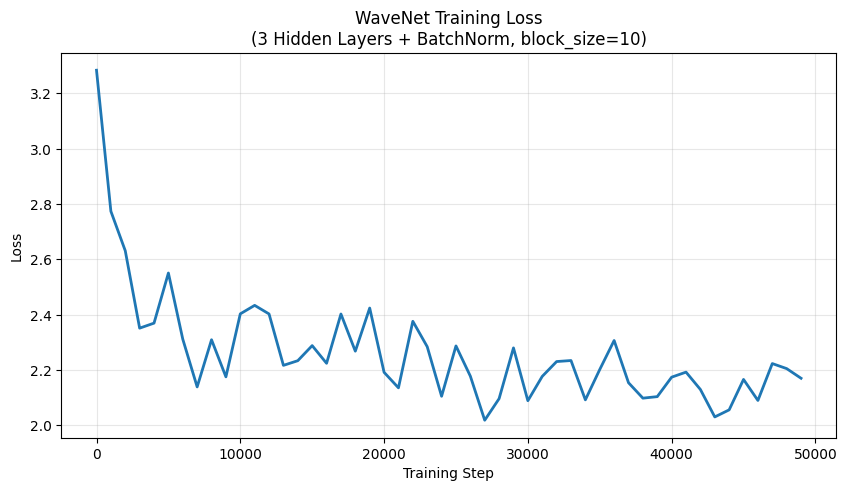


Training curve saved!


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(steps, lossi, linewidth=2)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('WaveNet Training Loss\n(3 Hidden Layers + BatchNorm, block_size=8)')
plt.grid(True, alpha=0.3)
plt.savefig('../outputs/wavenet_training_loss.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nTraining curve saved!")

## Part 4: Evaluation

In [9]:
@torch.no_grad()
def eval_split(X, Y):
    """
    Evaluate loss on a dataset split.
    Uses running BatchNorm statistics for inference.
    """
    # Embedding
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    
    # Layer 1 (use running statistics)
    hpreact1 = embcat @ W1 + b1
    hpreact1 = bngain1 * (hpreact1 - bnmean_running1) / bnstd_running1 + bnbias1
    h1 = torch.tanh(hpreact1)
    
    # Layer 2 (use running statistics)
    hpreact2 = h1 @ W2 + b2
    hpreact2 = bngain2 * (hpreact2 - bnmean_running2) / bnstd_running2 + bnbias2
    h2 = torch.tanh(hpreact2)
    
    # Layer 3 (use running statistics)
    hpreact3 = h2 @ W3 + b3
    hpreact3 = bngain3 * (hpreact3 - bnmean_running3) / bnstd_running3 + bnbias3
    h3 = torch.tanh(hpreact3)
    
    # Output
    logits = h3 @ Wout + bout
    loss = F.cross_entropy(logits, Y)
    
    return loss.item()

# Evaluate on all splits
train_loss = eval_split(Xtr, Ytr)
val_loss = eval_split(Xval, Yval)
test_loss = eval_split(Xte, Yte)

print("\nWaveNet Final Results:")
print(f"  Train Loss: {train_loss:.4f}")
print(f"  Val Loss:   {val_loss:.4f}")
print(f"  Test Loss:  {test_loss:.4f}")


WaveNet Final Results:
  Train Loss: 2.1214
  Val Loss:   2.1409
  Test Loss:  2.1408


## Part 5: Generate Names

In [10]:
@torch.no_grad()
def generate_name(max_length=20):
    """Generate a name using the trained WaveNet model."""
    name = []
    context = [dataset.stoi['.']] * block_size
    
    while True:
        # Prepare input
        x = torch.tensor([context])
        
        # Forward pass (inference mode)
        emb = C[x]
        embcat = emb.view(1, -1)
        
        # Layer 1
        hpreact1 = embcat @ W1 + b1
        hpreact1 = bngain1 * (hpreact1 - bnmean_running1) / bnstd_running1 + bnbias1
        h1 = torch.tanh(hpreact1)
        
        # Layer 2
        hpreact2 = h1 @ W2 + b2
        hpreact2 = bngain2 * (hpreact2 - bnmean_running2) / bnstd_running2 + bnbias2
        h2 = torch.tanh(hpreact2)
        
        # Layer 3
        hpreact3 = h2 @ W3 + b3
        hpreact3 = bngain3 * (hpreact3 - bnmean_running3) / bnstd_running3 + bnbias3
        h3 = torch.tanh(hpreact3)
        
        # Output
        logits = h3 @ Wout + bout
        probs = F.softmax(logits, dim=1)
        
        # Sample next character
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # Stop at period
        if ix == dataset.stoi['.']:
            break
        
        # Add to name
        name.append(dataset.itos[ix])
        
        # Update context (slide window)
        context = context[1:] + [ix]
        
        # Prevent infinite loops
        if len(name) >= max_length:
            break
    
    return ''.join(name)

# Generate sample names
print("\nGenerated names from WaveNet (block_size=8, 3 layers):\n")
generated_names = []
for i in range(30):
    name = generate_name()
    generated_names.append(name)
    print(f"{i+1:2d}. {name}")


Generated names from WaveNet (block_size=8, 3 layers):

 1. koagelli
 2. keaslina
 3. falenta
 4. runnester
 5. kaebuy
 6. latray
 7. rachal
 8. lyerain
 9. keyonn
10. malaeo
11. daydell
12. elera
13. ralleke
14. aleyn
15. geftrain
16. saliy
17. tygynne
18. kiaslyn
19. vavera
20. tanica
21. jazaimine
22. beardell
23. marelyn
24. enonie
25. myrline
26. eldom
27. zyvel
28. latrellsa
29. evetha
30. emuriona


## Part 6: Complete Model Comparison

In [11]:
# Store all model results
bigram_loss = 2.4647
mlp_loss = 2.4015
mlp_bn_loss = 2.2557
wavenet_loss = val_loss

print("\n" + "="*80)
print("COMPLETE MODEL COMPARISON - ALL 4 ARCHITECTURES")
print("="*80)
print(f"\n{'Model':<30} {'Val Loss':<12} {'Parameters':<12} {'Context'}")
print("-"*80)
print(f"{'1. Bigram':<30} {bigram_loss:<12.4f} {'729':<12} {'1 char'}")
print(f"{'2. MLP':<30} {mlp_loss:<12.4f} {'11,897':<12} {'3 chars'}")
print(f"{'3. MLP + BatchNorm':<30} {mlp_bn_loss:<12.4f} {'12,297':<12} {'3 chars'}")
print(f"{'4. WaveNet (3 layers + BN)':<30} {wavenet_loss:<12.4f} {f'{total_params:,}':<12} {'8 chars'}")
print("="*80)

# Calculate improvements
print(f"\nImprovements:")
print(f"  Bigram → MLP:           {bigram_loss - mlp_loss:+.4f} ({(bigram_loss - mlp_loss)/bigram_loss*100:.1f}%)")
print(f"  MLP → MLP+BN:           {mlp_loss - mlp_bn_loss:+.4f} ({(mlp_loss - mlp_bn_loss)/mlp_loss*100:.1f}%)")
print(f"  MLP+BN → WaveNet:       {mlp_bn_loss - wavenet_loss:+.4f} ({(mlp_bn_loss - wavenet_loss)/mlp_bn_loss*100:.1f}%)")
print(f"  ─────────────────────────────────────")
print(f"  Total (Bigram → WaveNet): {bigram_loss - wavenet_loss:+.4f} ({(bigram_loss - wavenet_loss)/bigram_loss*100:.1f}%)")

if wavenet_loss < mlp_bn_loss:
    print(f"\nWaveNet is our BEST model! ({wavenet_loss:.4f})")
else:
    print(f"\nWaveNet didn't beat MLP+BN. Possible reasons:")
    print(f"   - Needs more training")
    print(f"   - Hyperparameters not optimal")
    print(f"   - Deeper networks harder to train")

print("="*80)


COMPLETE MODEL COMPARISON - ALL 4 ARCHITECTURES

Model                          Val Loss     Parameters   Context
--------------------------------------------------------------------------------
1. Bigram                      2.4647       729          1 char
2. MLP                         2.4015       11,897       3 chars
3. MLP + BatchNorm             2.2557       12,297       3 chars
4. WaveNet (3 layers + BN)     2.1409       107,497      8 chars

Improvements:
  Bigram → MLP:           +0.0632 (2.6%)
  MLP → MLP+BN:           +0.1458 (6.1%)
  MLP+BN → WaveNet:       +0.1148 (5.1%)
  ─────────────────────────────────────
  Total (Bigram → WaveNet): +0.3238 (13.1%)

WaveNet is our BEST model! (2.1409)


### Visualize Complete Comparison

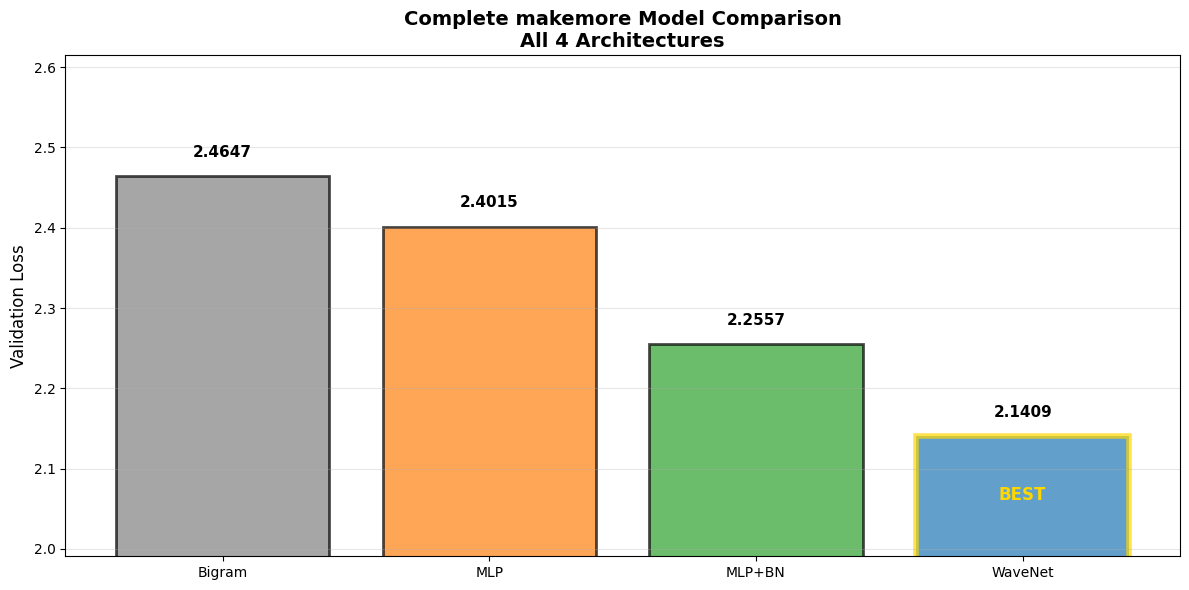


Comparison plot saved!


In [12]:
# Create comprehensive comparison plot
fig, ax = plt.subplots(figsize=(12, 6))

models = ['Bigram', 'MLP', 'MLP+BN', 'WaveNet']
losses = [bigram_loss, mlp_loss, mlp_bn_loss, wavenet_loss]
colors = ['gray', '#ff7f0e', '#2ca02c', '#1f77b4']

bars = ax.bar(models, losses, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Complete makemore Model Comparison\nAll 4 Architectures', fontsize=14, fontweight='bold')
ax.set_ylim([min(losses) - 0.15, max(losses) + 0.15])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, loss in zip(bars, losses):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{loss:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Highlight best model
best_idx = losses.index(min(losses))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)
ax.text(best_idx, losses[best_idx] - 0.08, 'BEST', 
        ha='center', fontsize=12, fontweight='bold', color='gold')

plt.tight_layout()
plt.savefig('../outputs/complete_model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nComparison plot saved!")

## Part 7: MLflow Logging

In [ ]:
# Configure MLflow
mlflow_tracking_uri = f"file://{os.path.abspath('../mlruns')}"
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment("makemore-wavenet")

print("\nLogging to MLflow...")

with mlflow.start_run(run_name="wavenet_3layers_block8"):
    # Log parameters
    mlflow.log_param("model_type", "wavenet")
    mlflow.log_param("block_size", block_size)
    mlflow.log_param("n_embd", n_embd)
    mlflow.log_param("n_hidden", n_hidden)
    mlflow.log_param("n_layers", 3)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_steps", num_steps)
    mlflow.log_param("total_parameters", total_params)
    mlflow.log_param("random_seed", RANDOM_SEED)
    
    # Log metrics
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("improvement_vs_bigram", bigram_loss - val_loss)
    mlflow.log_metric("improvement_vs_mlp", mlp_loss - val_loss)
    mlflow.log_metric("improvement_vs_mlp_bn", mlp_bn_loss - val_loss)
    
    # Log artifacts
    mlflow.log_artifact("../outputs/wavenet_training_loss.png")
    mlflow.log_artifact("../outputs/complete_model_comparison.png")
    
    # Save generated names
    with open('../outputs/wavenet_generated_names.txt', 'w') as f:
        for name in generated_names:
            f.write(name + '\n')
    mlflow.log_artifact("../outputs/wavenet_generated_names.txt")
    
    print("Logged to MLflow!")

print("\nWaveNet experiment complete!")
print("   Check MLflow UI: http://127.0.0.1:5000")
print("   Experiment: makemore-wavenet")


Logging to MLflow...
Logged to MLflow!

WaveNet experiment complete!
   Check MLflow UI: http://127.0.0.1:5000
   Experiment: makemore-wavenet
